In [120]:
# imports
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
%matplotlib inline

In [121]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


ETL

In [122]:
y = data['Outcome']
X = data.drop('Outcome', axis=1)

Note that this data contains no missing values

In [123]:
X.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

The following columns contain outliers:
Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age 

In [124]:
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [125]:
X.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
dtype: object

In [126]:
X.Pregnancies = X.Pregnancies.astype('float64')
X.Glucose = X.Glucose.astype('float64')
X.BloodPressure = X.BloodPressure.astype('float64')
X.SkinThickness = X.SkinThickness.astype('float64')
X.Insulin = X.Insulin.astype('float64')
X.Age = X.Age.astype('float64')
X.dtypes

Pregnancies                 float64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                         float64
dtype: object

In [127]:
# This is where we removed the outliers and replaced them with the median.
# It is ideal to use the median rather than the mean as the mean can be thrown off by outliers.

print(X['Pregnancies'].quantile(0.50)) 
print(X['Pregnancies'].quantile(0.997)) 
X['Pregnancies'] = np.where(X['Pregnancies'] > 14, 3, X['Pregnancies'])

print(X['Glucose'].quantile(0.50)) 
print(X['Glucose'].quantile(0.997)) 
X['Glucose'] = np.where(X['Glucose'] > 197, 117, X['Glucose'])

print(X['BloodPressure'].quantile(0.50)) 
print(X['BloodPressure'].quantile(0.997)) 
X['BloodPressure'] = np.where(X['BloodPressure'] > 110, 72, X['BloodPressure'])

print(X['SkinThickness'].quantile(0.50)) 
print(X['SkinThickness'].quantile(0.997)) 
X['SkinThickness'] = np.where(X['SkinThickness'] > 58, 23, X['SkinThickness'])

print(X['Insulin'].quantile(0.50)) 
print(X['Insulin'].quantile(0.997)) 
X['Insulin'] = np.where(X['Insulin'] > 57, 23, X['Insulin'])

print(X['Age'].quantile(0.50)) 
print(X['Age'].quantile(0.997)) 
X['Age'] = np.where(X['Age'] > 69, 29, X['Age'])



3.0
14.0
117.0
197.0
72.0
110.0
23.0
58.79599999999982
30.5
655.9199999999964
29.0
69.69899999999996


In [128]:
# sns.pairplot(new_X)

Note that none of the features in the dataset are strongly correlated meaning we can assume them to be independent for the sake of creating this model

In [129]:
corr_mat = X.corr()
corr_mat

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.129875,0.138887,-0.085028,-0.172720,0.008705,-0.035304,0.550214
Glucose,0.129875,1.000000,0.153693,0.032353,-0.062367,0.214198,0.128724,0.271222
BloodPressure,0.138887,0.153693,1.000000,0.217694,0.075728,0.284595,0.046180,0.259619
SkinThickness,-0.085028,0.032353,0.217694,1.000000,0.492436,0.382859,0.162311,-0.130449
Insulin,-0.172720,-0.062367,0.075728,0.492436,1.000000,0.079743,0.115526,-0.221444
BMI,0.008705,0.214198,0.284595,0.382859,0.079743,1.000000,0.140647,0.049093
DiabetesPedigreeFunction,-0.035304,0.128724,0.046180,0.162311,0.115526,0.140647,1.000000,0.032631
Age,0.550214,0.271222,0.259619,-0.130449,-0.221444,0.049093,0.032631,1.000000


In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

In [131]:
# This is where we instantiate model
model = GaussianNB()

# This is where we train the model
model.fit(X_train,y_train)

# This is where we get the coefficient of determination by applying our testing data.
# The coefficient of determination is fairly strong.
model.score(X_test,y_test)

0.7604166666666666

In [132]:
# Here we predict with the Gaussian Naive Bayes model.
# We can see that it didn't guess right twice.
# Two times it predicted the patient would have diabetes when he/she didn't have diabetes.
y_pred = model.predict(X_test)

In [133]:
# Here is the confusion matrix for the Gaussian Naive Bayes model. 
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix


array([[109,  21],
       [ 25,  37]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

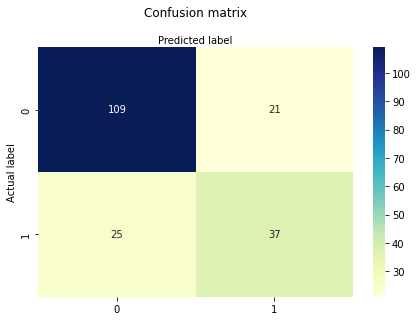

In [134]:
# Here we visualize the  Gaussian Naive Bayes confusion matrix using Heatmap.
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Here we compare this algorithim with Logistic Regression

In [135]:
# Lasso with 5 fold cross-validation
log_reg = LogisticRegressionCV(cv=5, random_state=0, max_iter=10000)

# Fit model
log_reg.fit(X_train, y_train)

# Here I check the coefficient of determination using Logistic Regression.
# We can see that it tested a little better than the Gaussian Naive Bayes model:
log_reg.score(X_test,y_test)

0.7760416666666666

In [136]:
# Here we predict with the Logistic Regression Model.
# We can see that it didn't guess right once.
# One time it predicted the patient would have diabetes when he/she didn't have diabetes.
y_pred = log_reg.predict(X_test)

In [137]:
# Here is the confusion matrix for the Logistic Regression model. 
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix


array([[113,  17],
       [ 26,  36]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

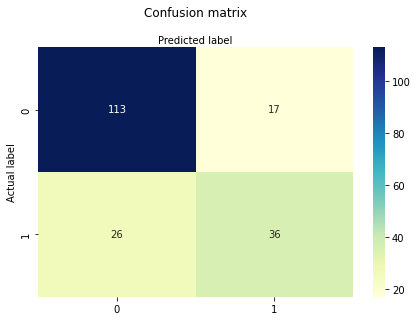

In [138]:
# Here we visualize the Logistic Regression confusion matrix using Heatmap.
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')